# Gaussian Process on the Wiggle dataset
## Exact inference

# Github

In [3]:
from google.colab import drive # For github
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Project18/GPs
!git config --global user.email "alexander.sabelstrom.1040@student.uu.se"
!git config --global user.name "Sabelz"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Project18/GPs


# Imports

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


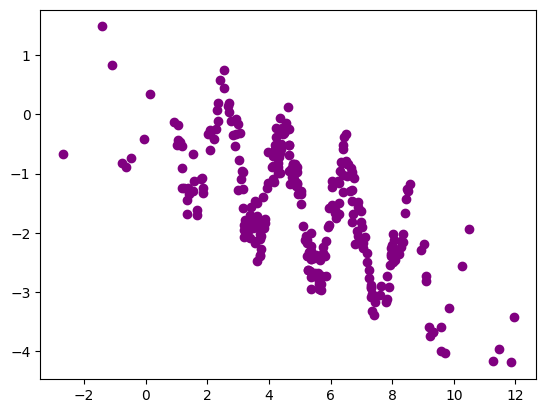

To https://github.com/Sabelz/Project18.git
 ! [rejected]        main -> main (fetch first)
error: failed to push some refs to 'https://github.com/Sabelz/Project18.git'
hint: Updates were rejected because the remote contains work that you do
hint: not have locally. This is usually caused by another repository pushing
hint: to the same ref. You may want to first integrate the remote changes
hint: (e.g., 'git pull ...') before pushing again.
hint: See the 'Note about fast-forwards' in 'git push --help' for details.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import gpytorch
#!pip install gpytorch
%matplotlib inline
%load_ext autoreload
%autoreload 2
%run ../datasets/wiggle.ipynb # Run the wiggle notebook which is in the same folder(Wiggle dataset)

# Training Data from wiggle

In [5]:
xTrain, yTrain = x, samples # x, samples are defined in ../datasets/wiggle.ipynb
xTrain, yTrain = torch.from_numpy(xTrain), torch.from_numpy(yTrain) # Convert them to tensors

# The GP model

In [6]:
# Class for the GP model(Exact GP)
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean() # Decide which mean to use
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) # Decide which kernel to use
    # GP Posterior predictive distribution
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize the first model

In [7]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood() # Decide likelihood
model = GPModel(xTrain, yTrain, likelihood) # For the first example, RBF kernel is used

# Train the Model

In [8]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters


mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model) # Decide loss

training_iterations = 50 # Decide training iterations
for i in range(training_iterations):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(xTrain)
    # Calc loss and backprop gradients
    loss = -mll(output, xTrain)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iterations, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 1.632   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 1.493   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 1.368   lengthscale: 0.798   noise: 0.598
Iter 4/50 - Loss: 1.255   lengthscale: 0.853   noise: 0.554
Iter 5/50 - Loss: 1.152   lengthscale: 0.910   noise: 0.513
Iter 6/50 - Loss: 1.058   lengthscale: 0.968   noise: 0.473
Iter 7/50 - Loss: 0.971   lengthscale: 1.026   noise: 0.437
Iter 8/50 - Loss: 0.890   lengthscale: 1.086   noise: 0.402
Iter 9/50 - Loss: 0.814   lengthscale: 1.145   noise: 0.369
Iter 10/50 - Loss: 0.743   lengthscale: 1.204   noise: 0.339
Iter 11/50 - Loss: 0.675   lengthscale: 1.263   noise: 0.310
Iter 12/50 - Loss: 0.610   lengthscale: 1.321   noise: 0.284
Iter 13/50 - Loss: 0.547   lengthscale: 1.378   noise: 0.259
Iter 14/50 - Loss: 0.486   lengthscale: 1.434   noise: 0.237
Iter 15/50 - Loss: 0.426   lengthscale: 1.489   noise: 0.216
Iter 16/50 - Loss: 0.368   lengthscale: 1.543   noise: 0.196
Iter 17/50 - Loss: 0.310   length

# Test Data

In [9]:
# Observing the plot of the wiggle dataset, x varies between -2-12
xTest = torch.linspace(-2, 12, 50)

# The posterior mean, variance and Covariance Matrix

In [174]:
model.eval() # eval mode is for computing predictions through the model posterior
f_preds = model(xTest) # returns the model posterior distribution p(f* | x*, X, y), for training data X, y

f_mean = f_preds.mean # Predictive mean
f_var = f_preds.variance # Predictive variance
f_covar = f_preds.covariance_matrix # Covariance matrix
print("Mean Dimension: ", f_mean.size())
print()
print("Variance Dimension: ", f_var.size())
print()
print("CovMatrix Dimension ", f_covar.size())

Mean Dimension:  torch.Size([50])

Variance Dimension:  torch.Size([50])

CovMatrix Dimension  torch.Size([50, 50])


# Predictive Distribution

In [11]:
model.eval() # eval mode is for computing predictions through the model posterior.
likelihood.eval()
y_preds = likelihood(model(xTest)) # gives us the posterior predictive distribution p(y* | x*, X, y) which is the probability distribution over the predicted output value

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
    observed_pred = y_preds

# Plot with RBF kernel

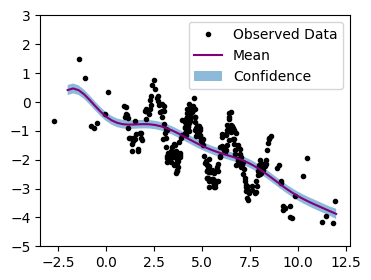

In [29]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(xTrain.numpy(), yTrain.numpy(), 'k.')
    # Plot predictive means as blue line
    ax.plot(xTest.numpy(), observed_pred.mean.numpy(), 'purple')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(xTest.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-5, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

# GP with a periodic kernel instead

In [24]:
# Class for the GP model(Exact GP)
class GPModelPeriodic(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModelPeriodic, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean() # Decide which mean to use
        # This kernel adds the RBF kernel with a Periodic kernel
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) # Decide which kernel to use
    # GP Posterior predictive distribution
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood2 = gpytorch.likelihoods.GaussianLikelihood() # Decide likelihood
modelPeriodic = GPModelPeriodic(xTrain, yTrain, likelihood2) # Now kernel is changed to periodic
# Set the hyperparameters for the Periodic Kernel
#modelPeriodic.covar_module.period_length = 10.0  # Set the period length to 10

# Train the periodic model

In [25]:
# Find optimal model hyperparameters
modelPeriodic.train()
likelihood2.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(modelPeriodic.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters


mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, modelPeriodic) # Decide loss

training_iterations = 50 # Decide training iterations
for i in range(training_iterations):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = modelPeriodic(xTrain)
    # Calc loss and backprop gradients
    loss = -mll(output, xTrain)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iterations, loss.item(),
        modelPeriodic.covar_module.base_kernel.lengthscale.item(),
        modelPeriodic.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: -0.485   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: -0.629   lengthscale: 0.744   noise: 0.693
Iter 3/50 - Loss: -0.749   lengthscale: 0.798   noise: 0.693
Iter 4/50 - Loss: -0.850   lengthscale: 0.853   noise: 0.693
Iter 5/50 - Loss: -0.935   lengthscale: 0.909   noise: 0.693
Iter 6/50 - Loss: -1.006   lengthscale: 0.966   noise: 0.693
Iter 7/50 - Loss: -1.066   lengthscale: 1.024   noise: 0.693
Iter 8/50 - Loss: -1.117   lengthscale: 1.082   noise: 0.693
Iter 9/50 - Loss: -1.161   lengthscale: 1.140   noise: 0.693
Iter 10/50 - Loss: -1.198   lengthscale: 1.197   noise: 0.693
Iter 11/50 - Loss: -1.231   lengthscale: 1.255   noise: 0.693
Iter 12/50 - Loss: -1.259   lengthscale: 1.311   noise: 0.693
Iter 13/50 - Loss: -1.283   lengthscale: 1.367   noise: 0.693
Iter 14/50 - Loss: -1.305   lengthscale: 1.421   noise: 0.693
Iter 15/50 - Loss: -1.324   lengthscale: 1.475   noise: 0.693
Iter 16/50 - Loss: -1.340   lengthscale: 1.527   noise: 0.693
Iter 17/50 - Loss

# The posterior mean, variance and Covariance Matrix

In [26]:
modelPeriodic.eval() # eval mode is for computing predictions through the model posterior
f_preds2 = modelPeriodic(xTest) # returns the model posterior distribution p(f* | x*, X, y), for training data X, y

f_mean2 = f_preds2.mean # Predictive mean
f_var2 = f_preds2.variance # Predictive variance
f_covar2 = f_preds2.covariance_matrix # Covariance matrix
print("Mean Dimension: ", f_mean2.size())
print()
print("Variance Dimension: ", f_var2.size())
print()
print("CovMatrix Dimension ", f_covar2.size())

Mean Dimension:  torch.Size([50])

Variance Dimension:  torch.Size([50])

CovMatrix Dimension  torch.Size([50, 50])


# Predictive Distribution

In [27]:
modelPeriodic.eval() # eval mode is for computing predictions through the model posterior.
likelihood2.eval()
y_preds2 = likelihood2(modelPeriodic(xTest)) # gives us the posterior predictive distribution p(y* | x*, X, y) which is the probability distribution over the predicted output value

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
    observed_pred2 = y_preds2

# Plot the periodic GP

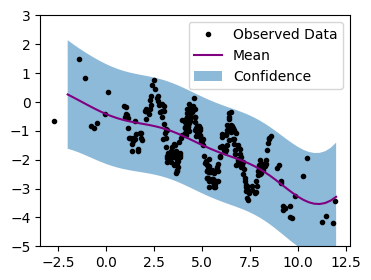

In [28]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred2.confidence_region()
    # Plot training data as black stars
    ax.plot(xTrain.numpy(), yTrain.numpy(), 'k.')
    # Plot predictive means as blue line
    ax.plot(xTest.numpy(), observed_pred2.mean.numpy(), 'purple')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(xTest.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-5, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [35]:
!git add "GPWiggle.ipynb"

fatal: pathspec 'GPWiggle.ipynb' did not match any files
